In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
import numpy as np
from torchvision import datasets, transforms
from skimage import io
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import scipy

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [ ]:
#@title Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/Final Project/'

/content/drive/.shortcut-targets-by-id/1HlCqMYdskIeVk8-T-oFvvmy2xBrAACpI/Final Project


In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks/CIS 522/Final Project/"

/content/drive/MyDrive/Colab Notebooks/CIS 522/Final Project


## Dice Loss

In [ ]:
from torch.autograd import Function

class DiceCoeff(Function):
    """Dice coeff for individual examples"""


    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)


## UNet

In [ ]:
class Block(nn.Module):
  #TODO: initialize layers??
  def __init__(self, in_channels, out_channels, device):
    super(Block, self).__init__()
    self.device = device
    self.intermediate_layers = {}
    self.out_channels = out_channels
    #Layer 1
    self.conv1_1 = nn.Conv2d(in_channels, out_channels, kernel_size = (3,3), padding=1)

    #Layer 2
    self.intermediate_layers[2] = self.create_subsequent_layers()
    #Layer 
    self.intermediate_layers[3] = self.create_subsequent_layers()
    #Layer 4
    self.intermediate_layers[4] = self.create_subsequent_layers()
    #Layer 5
    self.intermediate_layers[5] = self.create_subsequent_layers()
  
  def create_subsequent_layers(self):
    #To check: am I re-initializing this sequential layer every time I call the 
    return nn.Sequential(nn.BatchNorm2d(self.out_channels), 
                         nn.ReLU(), 
                         nn.Conv2d(self.out_channels, self.out_channels, kernel_size = (3,3), padding=1)).to(self.device)
  
  def forward(self, x):
    #Input layer
    x_1 = self.conv1_1(x)
    x_2 = self.intermediate_layers[2](x_1)
    x_2a = x_1+x_2

    x_3 = self.intermediate_layers[3](x_2a)
    x_3a = x_1+x_3

    x_4 = self.intermediate_layers[4](x_3a)
    x_4a = x_1+x_4

    #Output layer
    x_5 = self.intermediate_layers[5](x_4a)
    x_5a = x_1+x_5
    return x_5a

In [ ]:
class UNet(nn.Module):
  def __init__(self, device):
    super(UNet, self).__init__()
    ##Encoder
    self.device = device
    self.encoder_block1 = Block(3, 64, device)
    self.max_pool1 = nn.MaxPool2d(kernel_size =(2,2), stride = 2)
    self.encoder_block2 = Block(64, 128, device)
    self.max_pool2 = nn.MaxPool2d(kernel_size =(2,2), stride = 2)
    self.encoder_block3 = Block(128, 256, device)
    self.max_pool3 = nn.MaxPool2d(kernel_size =(2,2), stride = 2)


    #Bridge
    self.bridge = Block(256, 512, device)

    ##Decoder
    self.upsample_1 = nn.ConvTranspose2d(512, 256, kernel_size = (2,2), stride = 2)
    self.decoder_block1 = Block(512, 256, device)
    self.upsample_2 = nn.ConvTranspose2d(256, 128, kernel_size = (2,2), stride = 2)
    self.decoder_block2 = Block(256, 128, device)
    self.upsample_3 = nn.ConvTranspose2d(128, 64, kernel_size = (2,2), stride = 2)
    self.decoder_block3 = Block(128, 64, device)

    ##Output
    self.output_conv = nn.Conv2d(64, 1, kernel_size =(1,1), stride = 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #B, N, N, C --> B, C, N, N
    # x = x.permute(0, 3, 1, 2)

    ##Encoder
    x_e1 = self.encoder_block1(x) #--> decoder layer 3
    x_e2 = self.max_pool1(x_e1) 

    x_e2 = self.encoder_block2(x_e2)  #--> decoder layer 2
    x_e3 = self.max_pool2(x_e2)

    x_e3 = self.encoder_block3(x_e3)#--> decoder layer 1
    x_e4 = self.max_pool3(x_e3)

    #Bridge
    x_b = self.bridge(x_e4)

    #Decoder
    x_d1 = self.upsample_1(x_b)
    x_d1 = torch.cat((x_e3, x_d1), dim = 1)
    x_d2 = self.decoder_block1(x_d1)

    x_d2 = self.upsample_2(x_d2)
    x_d2 = torch.cat((x_e2, x_d2), dim = 1)
    x_d3 = self.decoder_block2(x_d2)

    x_d3 = self.upsample_3(x_d3)
    x_d3 = torch.cat((x_e1, x_d3), dim = 1)
    x_d4 = self.decoder_block3(x_d3)

    x_out = self.output_conv(x_d4)
    x_out = self.sigmoid(x_out)
    return x_out

In [ ]:
class UNet_Medium(nn.Module):
  def __init__(self, device):
    super(UNet_Medium, self).__init__()
    ##Encoder
    self.device = device
    self.encoder_block1 = Block(3, 64, device)
    self.max_pool1 = nn.MaxPool2d(kernel_size =(2,2), stride = 2)
    self.encoder_block2 = Block(64, 256, device)
    self.max_pool2 = nn.MaxPool2d(kernel_size =(2,2), stride = 2)
    # self.encoder_block3 = Block(128, 256, device)
    # self.max_pool3 = nn.MaxPool2d(kernel_size =(2,2), stride = 2)

    #Bridge
    self.bridge = Block(256, 512, device)

    ##Decoder
    # self.upsample_1 = nn.ConvTranspose2d(512, 256, kernel_size = (2,2), stride = 2)
    # self.decoder_block1 = Block(512, 256, device)
    self.upsample_2 = nn.ConvTranspose2d(512, 256, kernel_size = (2,2), stride = 2)
    self.decoder_block2 = Block(512, 256, device)
    self.upsample_3 = nn.ConvTranspose2d(256, 64, kernel_size = (2,2), stride = 2)
    self.decoder_block3 = Block(128, 64, device)

    ##Output
    self.output_conv = nn.Conv2d(64, 1, kernel_size =(1,1), stride = 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #B, N, N, C --> B, C, N, N
    # x = x.permute(0, 3, 1, 2)

    ##Encoder
    x_e1 = self.encoder_block1(x) #--> decoder layer 3
    x_e2 = self.max_pool1(x_e1) 

    x_e2 = self.encoder_block2(x_e2)  #--> decoder layer 2; size: 256
    x_e3 = self.max_pool2(x_e2)

    # x_e3 = self.encoder_block3(x_e3)#--> decoder layer 1
    # x_e4 = self.max_pool3(x_e3)

    #Bridge
    x_b = self.bridge(x_e3)

    #Decoder
    # x_d1 = self.upsample_1(x_b)
    # x_d1 = torch.cat((x_e3, x_d1), dim = 1)
    # x_d2 = self.decoder_block1(x_d1)

    x_d2 = self.upsample_2(x_b)
    x_d2 = torch.cat((x_e2, x_d2), dim = 1)
    x_d3 = self.decoder_block2(x_d2)

    x_d3 = self.upsample_3(x_d3)
    x_d3 = torch.cat((x_e1, x_d3), dim = 1)
    x_d4 = self.decoder_block3(x_d3)

    x_out = self.output_conv(x_d4)
    x_out = self.sigmoid(x_out)
    return x_out

## Crappy Net

In [ ]:
class CrappyNet(nn.Module):
    def __init__(self):
        super(CrappyNet, self).__init__()
        self.fc1 = nn.Linear(256*256*3, 256)
        self.fc2 = nn.Linear(256, 256*256)
    def forward(self, x):
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      return x

## Small UNet


In [ ]:
class UNetSmall(nn.Module):
  def __init__(self, device):
    super(UNetSmall, self).__init__()
    ##Encoder
    self.device = device
    self.encoder_block1 = Block(3, 32, device)
    self.max_pool1 = nn.MaxPool2d(kernel_size =(2,2), stride = 2)
    self.encoder_block2 = Block(32, 64, device)
    self.max_pool2 = nn.MaxPool2d(kernel_size =(2,2), stride = 2)


    #Bridge
    self.bridge = Block(64, 128, device)

    ##Decoder
    self.upsample_1 = nn.ConvTranspose2d(128, 64, kernel_size = (2,2), stride = 2)
    self.decoder_block1 = Block(128, 64, device)
    self.upsample_2 = nn.ConvTranspose2d(64, 32, kernel_size = (2,2), stride = 2)
    self.decoder_block2 = Block(64, 32, device)

    ##Output
    self.output_conv = nn.Conv2d(32, 1, kernel_size =(1,1), stride = 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #B, N, N, C --> B, C, N, N
    # x = x.permute(0, 3, 1, 2)

    ##Encoder
    x_e1 = self.encoder_block1(x) #--> decoder layer 3
    x_e2 = self.max_pool1(x_e1) 
    
    x_e2 = self.encoder_block2(x_e2)  #--> decoder layer 2
    x_e3 = self.max_pool2(x_e2)


    #Bridge
    x_b = self.bridge(x_e3)

    #Decoder
    x_d1 = self.upsample_1(x_b)
    x_d1 = torch.cat((x_e2, x_d1), dim = 1)
    x_d2 = self.decoder_block1(x_d1)

    x_d2 = self.upsample_2(x_d2)
    x_d2 = torch.cat((x_e1, x_d2), dim = 1)
    x_d3 = self.decoder_block2(x_d2)

    x_out = self.output_conv(x_d3)
    x_out = self.sigmoid(x_out)
    return x_out

## DataLoader

In [ ]:
class MapDataset(Dataset):
  def __init__(self, image_path, mask_path, image_list, mask_list, transforms=None, eval = False):
    self.image_path = image_path
    self.images = image_list
    self.target_path = mask_path
    self.targets = mask_list
    self.transforms = transforms
    self.eval = eval
    print("Init Complete.")
  def __getitem__(self, index):
    # st = time.time()
    image = np.load(os.path.join(self.image_path, self.images[index]))
    #1. Normalize image
    if self.transforms:
      image_t = self.transforms(image)

    mask = np.load(os.path.join(self.target_path, self.targets[index]))
    mask = mask[:,:,0]
    mask[np.where(mask<=128)] = 0
    mask[np.where(mask != 0)] = 1
    #2. If doing augmentation, be sure to apply augmentation to mask as well

    # print("mask binarized")
    # et = time.time()
    # print("Time {}".format(et-st))
    if self.eval:
      print(self.images[index], index)
    return image_t, torch.tensor(mask), image
  def __len__(self):
      return len(self.images)

In [ ]:
class TrainTest:
  def __init__(self, image_path, mask_path):
    self.image_path = image_path
    self.mask_path =  mask_path
    self.images = np.array(os.listdir(self.image_path))
    self.targets = np.array(os.listdir(self.mask_path))
    self.randomize()
  
  def randomize(self):
    #create one splitting indices --> apply to both self.images, self.targets
    #split self.images, self.targets via random indices --> 
    size = len(self.images)
    indices = np.random.permutation(np.arange(size).astype(int))
    indices_train = indices[:int(size*0.9)]
    indices_valid = indices[int(size*0.9):]
    self.images_train = self.images[indices_train] #lists of names of the files
    self.images_valid = self.images[indices_valid]
    self.masks_train = self.targets[indices_train]
    self.masks_valid = self.targets[indices_valid]

  def create_datasets(self, transforms =None):
    train_dataset = MapDataset(self.image_path, self.mask_path, self.images_train, self.masks_train, transforms = transforms)
    validation_dataset = MapDataset(self.image_path, self.mask_path, self.images_valid, self.masks_valid, transforms = transforms, eval = True)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, num_workers = 4,batch_size=8, shuffle=True)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset,num_workers = 0, batch_size=8, shuffle=False)
    return train_dataloader, validation_dataloader

In [ ]:
tforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainTest = TrainTest("train2_resized_np_sat/", "train2_resized_np_mask/")
train_dataloader, validation_dataloader = trainTest.create_datasets(transforms = tforms)

Init Complete.
Init Complete.


## Training and Testing Function

In [ ]:
def IoU(pred, target): 
  batch_scores = []
  for mask1, mask2 in zip(pred, target):
    iou_score = smp.utils.metrics.IoU(threshold=0.5).forward(mask1, mask2)
    batch_scores.append(iou_score)
  return np.array(batch_scores)
def test(net, test_loader):
  net.eval()
  for _, data in enumerate(test_loader):
    images, labels, _ = data
    avg_score = 0
    counts = 0
    with torch.no_grad():
      images = images.to(device).float()
      labels = labels.float()

      pred = net(images).cpu()
      iou_score = IoU(pred, labels)
      avg_score += np.sum(iou_score)
      counts += iou_score.shape[0]
    return avg_score / counts

In [ ]:
def train_test(net, criterion, optimizer, 
               train_data_loader, device,
               num_epochs=5, verbose=True, training_plot=True):
  # train
  training_losses = []
  valid_stats = []
  for epoch in tqdm(range(num_epochs)):
    net.train()
    running_loss = []
    for i, data in tqdm(enumerate(train_data_loader)):
      # print(i)
      # get the data
      images, labels, _ = data
      # print("Time {}".format(et-st))
      images = images.to(device).float()
      # kernel = torch.tensor(([[[[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]] * 3] * 3)).to(device).float()
      # images = F.conv2d(images, kernel, padding=1, stride=[1, 1])
      labels = labels.to(device).float()
      # zero the parameter gradients
      optimizer.zero_grad()
      outputs = net(images).squeeze(1)
      # outputs = torch.reshape(outputs, (-1, 256, 256))
      weight = torch.zeros((labels.shape)).to(device)
      weight[torch.where(labels == 1)] = 0.9 #labels ==1, weight_matrix = x
      weight[torch.where(labels == 0)] = 0.1 #labels ==0, weight_matrix = (1-x)
      # weight[torch.where(torch.logical_and(labels == 0, outputs == 1))] = 0.8 #labels ==1, weight_matrix = x

      #DICE coefficient??
      assert weight.shape[0] == labels.shape[0]
      loss = dice_coeff(outputs, labels)
      # loss = loss*weight
      loss = loss.mean()
      loss.backward()
      optimizer.step()
      # print statistics
      training_losses += [loss.item()]
      running_loss.append(loss.item())
    # if epoch % 10 == 0:
    running_loss = np.array(running_loss)
    training_losses += [loss.item()]
    print("Loss {}".format(np.sum(running_loss)/len(running_loss)))
    valid_stats.append(test(net, validation_dataloader))
  if training_plot:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
    axes[0].plot(training_losses)
    axes[1].plot(valid_stats)
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Training loss')
    axes[1].set_ylabel('IOU Score')
    fig.tight_layout() 
    plt.show()

## Run!

In [ ]:
# #Data Exploration
# data = next(iter(dataloader))
# sat, mask, _ = data
# maskratio = (torch.sum(mask)/(mask.shape[0]*256*256))
# print("Ratio of 1's in mask: {}".format(maskratio))

In [ ]:
# device = "cuda"
# # net = UNet(device).to(device)
# net = CrappyNet().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters())
# train_test(net, criterion, optimizer, dataloader, device, num_epochs=20)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



Loss 0.001773698724323673
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 1.7662476735135436e-07
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 1.57249001897714e-07
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 1.305826707300915e-07
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 1.1759436720498721e-07
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 1.0555865262373146e-07
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 9.990669973609224e-08
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 9.467775079131054e-08
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 9.111769280443504e-08
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 8.90052130878413e-08
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 8.686799476414242e-08
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 8.595498014920841e-08
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



Loss 8.552468496852025e-08
441048_sat.jpg.npy 0
221165_sat.jpg.npy 1
714700_sat.jpg.npy 2
129120_sat.jpg.npy 3
632655_sat.jpg.npy 4
373615_sat.jpg.npy 5
88199_sat.jpg.npy 6
499882_sat.jpg.npy 7



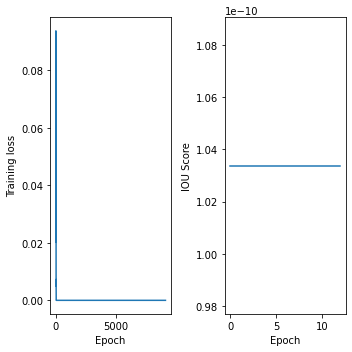

In [ ]:
device = "cuda"
# net = UNet(device).to(device)
net = UNet_Medium(device).to(device)
criterion = nn.BCELoss(reduce=False)
# criterion = dice_coeff
optimizer = optim.Adam(net.parameters(), lr=0.00008)
train_test(net, criterion, optimizer, train_dataloader, device, num_epochs=13)
# torch.save(net, "network3.pt")

In [ ]:
torch.save(net, "bestUNetMedium427-1.pt")

In [ ]:
device = "cuda"
net = torch.load("bestUNetMedium424-3.pt").to(device)

In [ ]:
data = next(iter(validation_dataloader))
sat, mask, sat_unnorm = data
net.eval()
pred = net(sat.to(device).float())

380317_sat.jpg.npy 0
37426_sat.jpg.npy 1
344261_sat.jpg.npy 2
869652_sat.jpg.npy 3
27127_sat.jpg.npy 4
202076_sat.jpg.npy 5
384950_sat.jpg.npy 6
626460_sat.jpg.npy 7


In [ ]:
idx = 7
pred_numpy = pred[idx].cpu().detach().numpy()

In [ ]:
binarized_numpy = np.copy(pred_numpy)
binarized_numpy[np.where(binarized_numpy >= 0.5)] = 1
binarized_numpy[np.where(binarized_numpy < 0.5)] = 0

In [ ]:
np.max(pred_numpy)

0.74380076

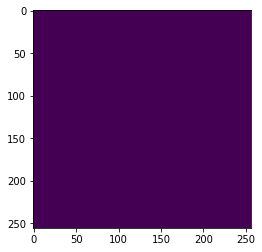

In [ ]:
bleh = np.zeros((pred_numpy.squeeze().shape))
plt.imshow(bleh)
plt.show()

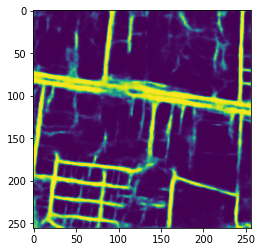

In [ ]:
plt.imshow(pred_numpy.squeeze())
plt.show()

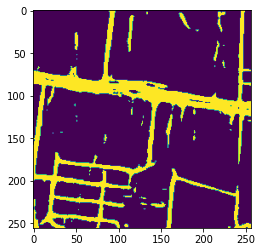

In [ ]:
#Binarized Output
plt.imshow(binarized_numpy.squeeze())
plt.show()

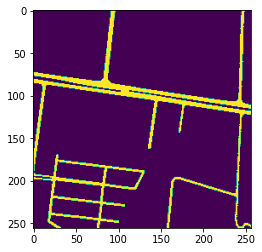

In [ ]:
mask_show = mask[idx]
plt.imshow(mask_show.squeeze())
plt.show()

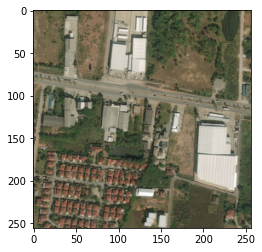

In [ ]:
plt.imshow(sat_unnorm[idx].squeeze())
plt.show()

In [ ]:
mkdir

In [ ]:
test(net, validation_dataloader)

380317_sat.jpg.npy 0
37426_sat.jpg.npy 1


KeyboardInterrupt: ignored